In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import random
from torch.utils.data import DataLoader, random_split, Subset

from sklearn.preprocessing import MinMaxScaler

import os
import argparse

from util.env import get_device, set_device
from util.preprocess import build_loc_net, construct_data
from util.net_struct import get_feature_map, get_fc_graph_struc
from util.iostream import printsep

from datasets.TimeDataset import TimeDataset


from models.GDN import GDN

/home/jiin/anaconda3/envs/gdn/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from evaluate import *
from train import train
from test  import test

In [12]:
random_seed = 5

random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
os.environ['PYTHONHASHSEED'] = str(random_seed)

train_config = {
        'batch': 32,
        'epoch': 30,
        'slide_win': 10,
        'dim': 64,
        'slide_stride': 1,
        'comment': "INFO-01",
        'seed': 5,
        'out_layer_num': 1,
        'out_layer_inter_dim': 128,
        'decay': 0,
        'val_ratio': 0.2,
        'topk': 3,
    }

env_config={
        'save_path': "INFO-01",
        'dataset': 'INFO-01',
        'report': 'best',
        'device': 1,
        'load_model_path': ''
    }

In [13]:
from main import Main

In [73]:
data_path = '../2. OTT_media/data/'
file_list = os.listdir(data_path)
f_names = [f[6:-4] for f in file_list if f != '.ipynb_checkpoints']
col_nums = [1,5,4,3]
servers = []
for i in range(len(f_names)):
    f = f_names[i]
    for j in range(col_nums[i]):
        servers.append(f + '-0' + str(j+1))
servers

['INFO-01',
 'LOGIN-01',
 'LOGIN-02',
 'LOGIN-03',
 'LOGIN-04',
 'LOGIN-05',
 'MENU-01',
 'MENU-02',
 'MENU-03',
 'MENU-04',
 'STREAM-01',
 'STREAM-02',
 'STREAM-03']

In [138]:
if os.listdir(model_path)[-1] == '.ipynb_checkpoint':
    print(os.listdir(model_path)[-2])
else:
    print(os.listdir(model_path)[-1])
# os.listdir(model_path).remove('.ipynb_checkpoint')

best_05|13-19:15:16.pt


In [159]:
for server in servers[:10]:

    print(server)
    
    model_path = './pretrained/{}'.format(server)
    model_save_path = os.listdir(model_path)
    try:
        model_save_path.remove('.ipynb_checkpoints')
    except:
        pass
    model_save_path = model_save_path[-1]       
    model_save_path = './pretrained/{}/'.format(server) + model_save_path

    ## load trained model
    env_config['save_path'] = server 
    env_config['dataset'] = server
    main = Main(train_config=train_config, env_config=env_config)
    
    main.model.load_state_dict(torch.load(model_save_path))
    best_model = main.model.to(main.device)

    _, test_result = test(best_model, main.test_dataloader)
    _, val_result = test(best_model, main.val_dataloader)
    final_err_scores = get_final_err_scores(test_result, val_result )

    ## select anomaly
    threshold = np.quantile(final_err_scores, 0.99)
    predict = [1 if final_err_scores[i] > threshold else 0 for i in range(len(final_err_scores))]
    for i in range(main.train_config['slide_win']):
        predict.insert(0, 0)
    predict = np.array(predict)

    ## save result
    test_data = pd.read_csv('data/{}/test.csv'.format(server), index_col=0)
    test_origin = pd.read_csv('data/{}/test_origin.csv'.format(server), index_col=0)
    test_origin['Prediction'] = 0
    test_origin.loc[test_data.index, 'Prediction'] = pd.Series(predict, index=test_data.index)

    ## save
    if test_origin.shape[0] == 105120:
        test_origin['Prediction'].to_csv('{}_result.csv'.format(server), index=False)
    else:
        print('test set length error')

INFO-01
LOGIN-01
LOGIN-02
LOGIN-03
LOGIN-04
LOGIN-05
MENU-01
MENU-02
MENU-03
MENU-04


In [160]:
result = []
for server in servers[:10]:
    out = pd.read_csv('{}_result.csv'.format(server))
    result.append(out)

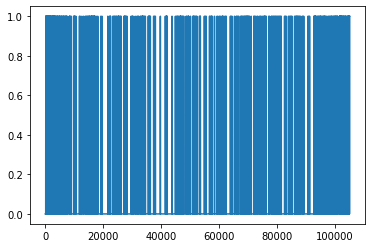

In [161]:
final_result = pd.concat(result, axis=1).sum(axis=1)
final_result = np.array([1 if f >= 1 else 0 for f in final_result])
plt.plot(final_result)

In [162]:
len([f for f in final_result if f==1]), len(final_result)

(4466, 105120)

In [163]:
pd.DataFrame(final_result, columns=['Prediction']).to_csv('final_result_0.99.csv', index=False)

In [ ]:
# 

In [39]:
model_save_path = './pretrained/INFO-01/best_05|13-16:34:52.pt'
    

main.model.load_state_dict(torch.load(model_save_path))
best_model = main.model.to(main.device)

In [40]:
_, test_result = test(best_model, main.test_dataloader)
_, val_result = test(best_model, main.val_dataloader)

# main.get_score(test_result, val_result)

In [41]:
final_err_scores = get_final_err_scores(test_result, val_result )

(0.0, 20.0)

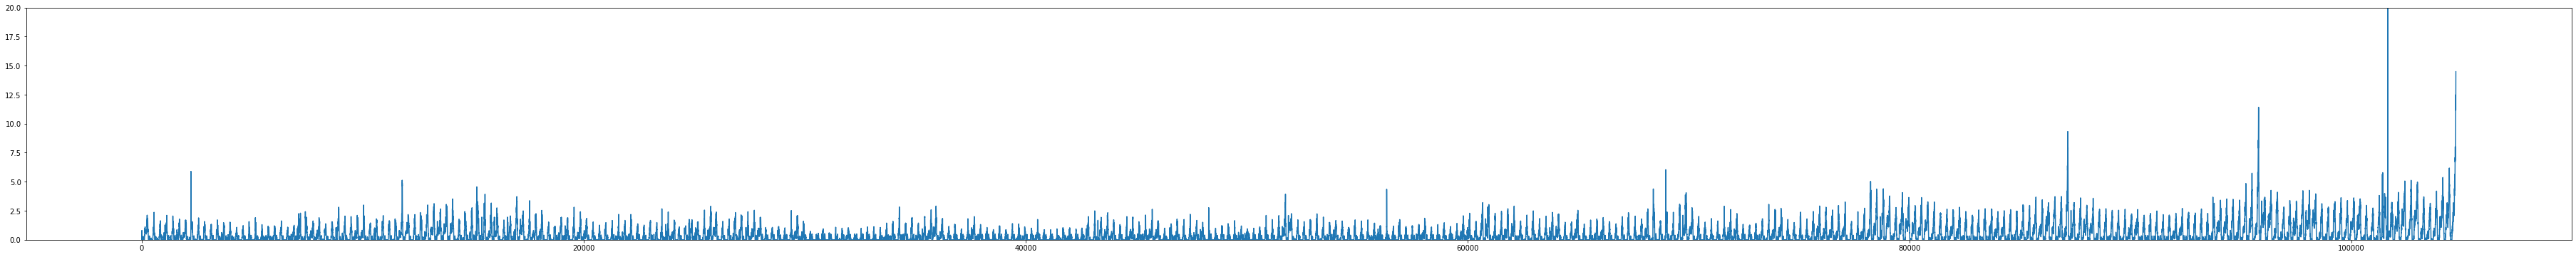

In [42]:
plt.figure(figsize=(64, 6))
plt.plot(final_err_scores)
plt.ylim(0, 20)

In [43]:
threshold = np.quantile(final_err_scores, 0.999)
predict = [1 if final_err_scores[i] > threshold else 0 for i in range(len(final_err_scores))]
for i in range(main.train_config['slide_win']):
    predict.insert(0, 0)
predict = np.array(predict)

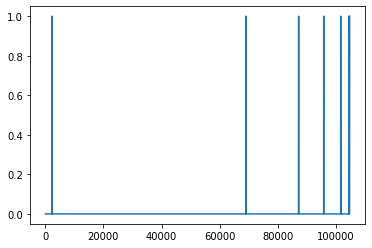

In [44]:
plt.plot(predict)

In [45]:
test_data = pd.read_csv('data/INFO-01/test.csv', index_col=0)
test_origin = pd.read_csv('data/INFO-01/test_origin.csv', index_col=0)
test_data

,INFO-01-Request,INFO-01-Success,INFO-01-Fail,attack
105120,3490.0,3490.0,0.0,0
105121,2152.0,2152.0,0.0,0
105122,1302.0,1302.0,0.0,0
105123,1100.0,1100.0,0.0,0
105124,1081.0,1081.0,0.0,0
...,...,...,...,...
210235,4988.0,4988.0,0.0,0
210236,5807.0,5807.0,0.0,0
210237,5716.0,5716.0,0.0,0
210238,5952.0,5952.0,0.0,0


In [50]:
test_data.index

Int64Index([105120, 105121, 105122, 105123, 105124, 105125, 105126, 105127,
            105128, 105129,
            ...
            210230, 210231, 210232, 210233, 210234, 210235, 210236, 210237,
            210238, 210239],
           dtype='int64', length=104741)

In [63]:
test_origin['prediction'] = 0
test_origin.loc[test_data.index, 'prediction'] = pd.Series(predict, index=test_data.index)

In [67]:
test_origin['prediction'].to_csv('INFO-01_result.csv')

In [68]:
test_origin.shape

(105120, 4)